In [14]:
import itertools
# import data handling tools 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
%matplotlib inline

# import Deep learning Libraries
from keras.layers import Flatten, Dense,BatchNormalization,Dropout
from keras.models import Model
from keras.applications import VGG19
from sklearn.metrics import confusion_matrix


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
print ('modules loaded')


modules loaded


In [2]:
data_dir = 'datasSet/pixel_data_32_32.csv'
data = pd.read_csv(data_dir)
#data.head(20)
data.shape

(10015, 3072)

In [3]:
df=pd.read_csv("datasSet\hmnist_28_28_RGB.csv")

In [4]:
Label = df["label"]
df = df.drop(columns=["label"])

In [5]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler()
data, Label  = oversample.fit_resample(data, Label)
data = np.array(data).reshape(-1, 32, 32, 3)
print('Shape of Data :', data.shape)

Shape of Data : (46935, 32, 32, 3)


In [6]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6], dtype=int64)

In [7]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [8]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(data , Label , test_size = 0.25 , random_state = 49)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35201, 32, 32, 3)
(35201,)
(11734, 32, 32, 3)
(11734,)


In [10]:
X_train=X_train/255.
X_test=X_test/255.

In [11]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [19]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
callback = EarlyStopping(monitor='loss',min_delta=0.01,
                                               patience=3)
checkpoint_filepath = 'models/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [20]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


for layer in base_model.layers:
    layer.trainable = False


x = Flatten()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(7, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [22]:
history=model.fit(X_train, y_train, batch_size=256, epochs=30, validation_data=(X_test, y_test),callbacks=[callback,model_checkpoint_callback])

Epoch 1/30
138/138 [==============================] - 128s 927ms/step - loss: 0.9427 - accuracy: 0.6372 - val_loss: 0.8016 - val_accuracy: 0.7083
Epoch 2/30
138/138 [==============================] - 133s 968ms/step - loss: 0.8854 - accuracy: 0.6566 - val_loss: 0.7387 - val_accuracy: 0.7320
Epoch 3/30
138/138 [==============================] - 139s 1s/step - loss: 0.8424 - accuracy: 0.6735 - val_loss: 0.7102 - val_accuracy: 0.7365
Epoch 4/30
138/138 [==============================] - 140s 1s/step - loss: 0.8025 - accuracy: 0.6902 - val_loss: 0.6859 - val_accuracy: 0.7506
Epoch 5/30
138/138 [==============================] - 141s 1s/step - loss: 0.7647 - accuracy: 0.7053 - val_loss: 0.6162 - val_accuracy: 0.7631
Epoch 6/30
138/138 [==============================] - 140s 1s/step - loss: 0.7327 - accuracy: 0.7206 - val_loss: 0.6149 - val_accuracy: 0.7728
Epoch 7/30
138/138 [==============================] - 140s 1s/step - loss: 0.7015 - accuracy: 0.7326 - val_loss: 0.5912 - val_accuracy: 

In [23]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

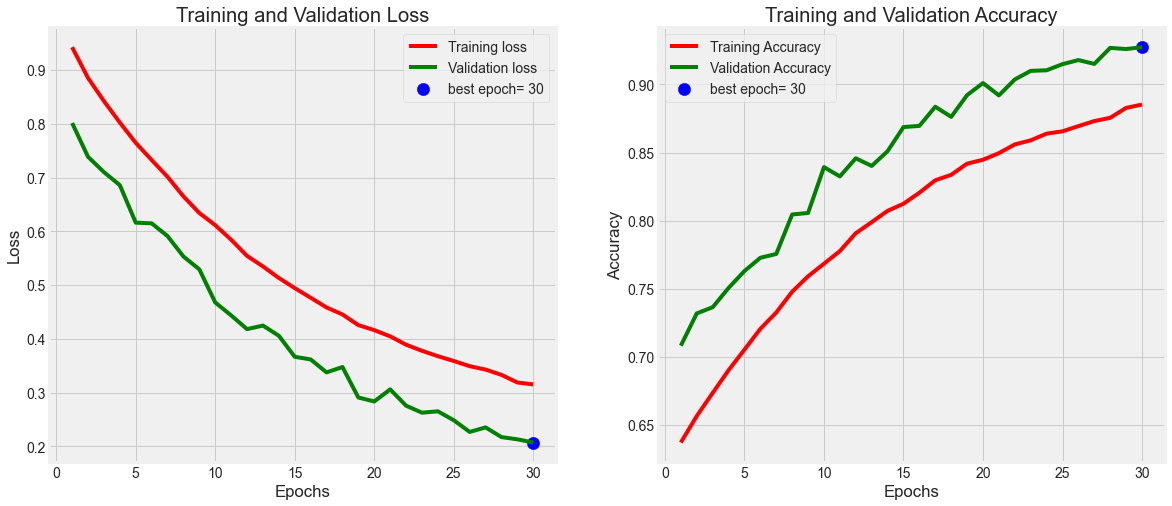

In [24]:
plot_training(history)

In [25]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

367/367 [==============================] - 55s 150ms/step - loss: 0.2071 - accuracy: 0.9274
Train Loss:  0.1402699500322342
Train Accuracy:  0.9528138637542725
--------------------
Test Loss:  0.2070641666650772
Test Accuracy:  0.9273905158042908


In [27]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

367/367 [==============================] - 46s 120ms/step


In [29]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


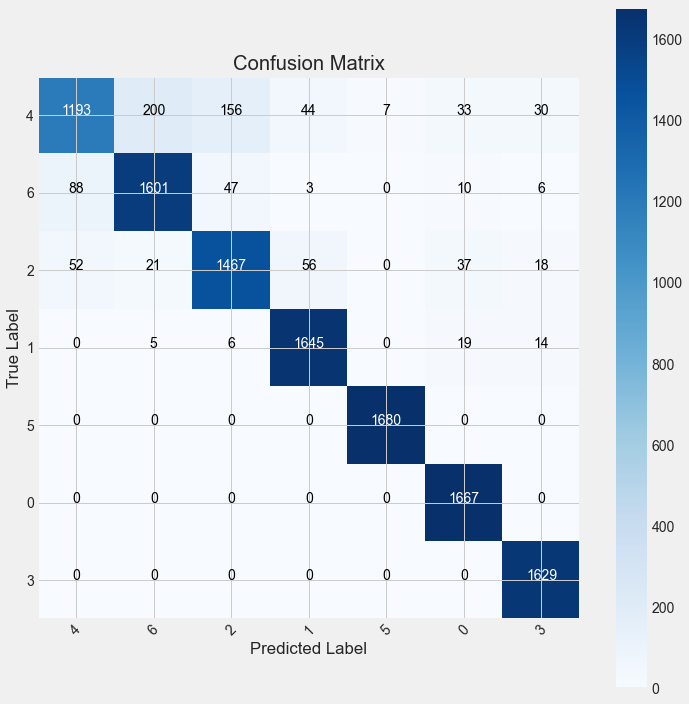

In [30]:
# Confusion matrix
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [31]:
#Save the model
model.save('models/version1.h5')